In [2]:
try:
    import openmdao.api as om
    import dymos as dm
except ImportError:
    !python -m pip install openmdao[notebooks]
    !python -m pip install dymos
    import openmdao.api as om
    import dymos as dm

# The Length-Constrained Brachistochrone

```{admonition} Things you'll learn through this example
    - How to connect the outputs from a trajectory to a downstream system.
```

This is a modified take on the brachistochrone problem.
In this instance, we assume that the quantity of wire available is limited.
Now, we seek to find the minimum time brachistochrone trajectory subject to a upper-limit on the arclength of the wire.

The most efficient way to approach this problem would be to treat the arc-length $S$ as an integrated state variable.
In this case, as is often the case in real-world MDO analyses, the implementation of our arc-length function is not integrated into our pseudospectral approach.
Rather than rewrite an analysis tool to accommodate the pseudospectral approach, the arc-length analysis simply takes the result of the trajectory in its entirety and computes the arc-length constraint via the trapezoidal rule:\

\begin{align}
    S &= \frac{1}{2} \left( \sum_{i=1}^{N-1} \sqrt{1 + \frac{1}{\tan{\theta_{i-1}}}} + \sqrt{1 + \frac{1}{\tan{\theta_{i}}}} \right) \left(x_{i-1} - x_i \right)
\end{align}

The OpenMDAO component used to compute the arclength is defined as follows:

In [3]:
from __future__ import print_function, division, absolute_import

import numpy as np

from openmdao.api import ExplicitComponent


class ArcLengthComp(ExplicitComponent):

    def initialize(self):

        self.options.declare('num_nodes', types=(int,))

    def setup(self):
        nn = self.options['num_nodes']

        self.add_input('x', val=np.ones(nn), units='m', desc='x at points along the trajectory')
        self.add_input('theta', val=np.ones(nn), units='rad',
                       desc='wire angle with vertical along the trajectory')

        self.add_output('S', val=1.0, units='m', desc='arclength of wire')

        self.declare_partials(of='S', wrt='*', method='cs')

    def compute(self, inputs, outputs, discrete_inputs=None, discrete_outputs=None):

        x = inputs['x']
        theta = inputs['theta']

        dy_dx = -1.0 / np.tan(theta)
        dx = np.diff(x)
        f = np.sqrt(1 + dy_dx**2)

        # trapezoidal rule
        fxm1 = f[:-1]
        fx = f[1:]
        outputs['S'] = 0.5 * np.dot(fxm1 + fx, dx)

```{Note}
In this example, the number of nodes used to compute the arclength is needed when building the problem.
The transcription object is initialized and its attribute `grid_data.num_nodes` is used to provide the number of total nodes (the number of points in the timeseries) to the downstream arc length calculation.
```

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Full total jacobian was computed 3 times, taking 0.343786 seconds.
Total jacobian shape: (220, 296) 


Jacobian shape: (220, 296)  ( 3.60% nonzero)
FWD solves: 4   REV solves: 14
Total colors vs. total size: 18 vs 220  (91.8% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 0.343786 sec.
Time to compute coloring: 0.352676 sec.
Memory to compute coloring: 0.058594 MB.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.808598520786357
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization Complete
-----------------------------------

Simulating trajectory traj
Done simulating trajectory traj


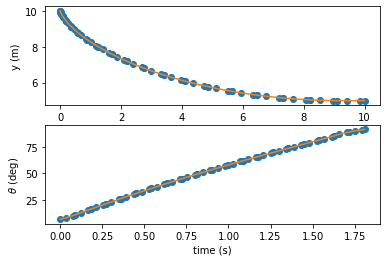

In [6]:
import openmdao.api as om
import dymos as dm
import matplotlib.pyplot as plt
from dymos.examples.brachistochrone.brachistochrone_ode import BrachistochroneODE
from dymos.examples.length_constrained_brachistochrone.arc_length_comp import ArcLengthComp

MAX_ARCLENGTH = 11.9
OPTIMIZER = 'SLSQP'

p = om.Problem(model=om.Group())
p.add_recorder(om.SqliteRecorder('length_constrained_brach_sol.db'))

if OPTIMIZER == 'SNOPT':
    p.driver = om.pyOptSparseDriver()
    p.driver.options['optimizer'] = OPTIMIZER
    p.driver.opt_settings['Major iterations limit'] = 1000
    p.driver.opt_settings['Major feasibility tolerance'] = 1.0E-6
    p.driver.opt_settings['Major optimality tolerance'] = 1.0E-5
    p.driver.opt_settings['iSumm'] = 6
    p.driver.opt_settings['Verify level'] = 3
else:
    p.driver = om.ScipyOptimizeDriver()

p.driver.declare_coloring()

# Create the transcription so we can get the number of nodes for the downstream analysis
tx = dm.Radau(num_segments=20, order=3, compressed=False)

traj = dm.Trajectory()
phase = dm.Phase(transcription=tx, ode_class=BrachistochroneODE)
traj.add_phase('phase0', phase)

p.model.add_subsystem('traj', traj)

phase.set_time_options(fix_initial=True, duration_bounds=(.5, 10))

phase.add_state('x', units='m', rate_source='xdot', fix_initial=True, fix_final=True)
phase.add_state('y', units='m', rate_source='ydot', fix_initial=True, fix_final=True)
phase.add_state('v', units='m/s', rate_source='vdot', fix_initial=True, fix_final=False)

phase.add_control('theta', units='deg', lower=0.01, upper=179.9,
                  continuity=True, rate_continuity=True)

phase.add_parameter('g', units='m/s**2', opt=False, val=9.80665)

# Minimize time at the end of the phase
phase.add_objective('time', loc='final', scaler=1)

# p.model.options['assembled_jac_type'] = top_level_jacobian.lower()
# p.model.linear_solver = DirectSolver(assemble_jac=True)

# Add the arc length component
p.model.add_subsystem('arc_length_comp',
                      subsys=ArcLengthComp(num_nodes=tx.grid_data.num_nodes))

p.model.connect('traj.phase0.timeseries.controls:theta', 'arc_length_comp.theta')
p.model.connect('traj.phase0.timeseries.states:x', 'arc_length_comp.x')

p.model.add_constraint('arc_length_comp.S', upper=MAX_ARCLENGTH, ref=1)

p.setup(check=True)

p.set_val('traj.phase0.t_initial', 0.0)
p.set_val('traj.phase0.t_duration', 2.0)

p.set_val('traj.phase0.states:x', phase.interp('x', [0, 10]))
p.set_val('traj.phase0.states:y', phase.interp('y', [10, 5]))
p.set_val('traj.phase0.states:v', phase.interp('v', [0, 9.9]))
p.set_val('traj.phase0.controls:theta', phase.interp('theta', [5, 100]))
p.set_val('traj.phase0.parameters:g', 9.80665)

p.run_driver()

p.record(case_name='final')


# Generate the explicitly simulated trajectory
exp_out = traj.simulate()

# Extract the timeseries from the implicit solution and the explicit simulation
x = p.get_val('traj.phase0.timeseries.states:x')
y = p.get_val('traj.phase0.timeseries.states:y')
t = p.get_val('traj.phase0.timeseries.time')
theta = p.get_val('traj.phase0.timeseries.controls:theta')

x_exp = exp_out.get_val('traj.phase0.timeseries.states:x')
y_exp = exp_out.get_val('traj.phase0.timeseries.states:y')
t_exp = exp_out.get_val('traj.phase0.timeseries.time')
theta_exp = exp_out.get_val('traj.phase0.timeseries.controls:theta')

fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].plot(x, y, 'o')
axes[0].plot(x_exp, y_exp, '-')
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')

axes[1].plot(t, theta, 'o')
axes[1].plot(t_exp, theta_exp, '-')
axes[1].set_xlabel('time (s)')
axes[1].set_ylabel(r'$\theta$ (deg)')

plt.show()